In [ ]:
import feature_engineering.preprocessing
import LSTM.model

import datetime
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

### UNIVARIATE TIME SERIES - ONLY CLOSE PRICE

In [ ]:
model = LSTM.model.build_model(num_features=1, lookback=50, horizon=1, learning_rate=1e-3)

In [ ]:
train_budimex, test_budimex, budimex_scaler = feature_engineering.preprocessing.load_train_test_data_from_tickers('BDX.WA', 
                                                datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'],
                                                scale=True, test_size=0.2, name_feature_to_predict='Close')
X_train_budimex, Y_train_budimex = feature_engineering.preprocessing.prepare_data_for_model(train_budimex, 50)

In [ ]:
test_budimex = budimex_scaler.transform(np.array(test_budimex).reshape(-1, 1))

In [ ]:
X_test_budimex, Y_test_budimex = feature_engineering.preprocessing.prepare_data_for_model(pd.DataFrame(test_budimex), 50)

In [ ]:
train_set, test_set = feature_engineering.preprocessing.train_test_split(
        feature_engineering.preprocessing.get_data_by_ticker('BDX.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close']),
                                                test_size=0.2)
X_train_budimex

array([[[0.43168051],
        [0.29979933],
        [0.58079785],
        ...,
        [0.09648176],
        [0.3572758 ],
        [0.49880225]],

       [[0.29979933],
        [0.58079785],
        [0.82300352],
        ...,
        [0.3572758 ],
        [0.49880225],
        [0.75779433]],

       [[0.58079785],
        [0.82300352],
        [0.22286905],
        ...,
        [0.49880225],
        [0.75779433],
        [0.6366914 ]],

       ...,

       [[0.33424591],
        [0.43975086],
        [0.24830002],
        ...,
        [0.37243239],
        [0.1912251 ],
        [0.30952345]],

       [[0.43975086],
        [0.24830002],
        [0.46888281],
        ...,
        [0.1912251 ],
        [0.30952345],
        [0.07822846]],

       [[0.24830002],
        [0.46888281],
        [0.120152  ],
        ...,
        [0.30952345],
        [0.07822846],
        [0.51317126]]])

In [ ]:
fit_model = model.fit(X_train_budimex, Y_train_budimex, epochs=100,
                    batch_size= 64,
                    shuffle=False, verbose=2)

Epoch 1/100
16/16 - 15s - loss: 0.0238 - mean_absolute_error: 0.1776 - 15s/epoch - 919ms/step
Epoch 2/100
16/16 - 9s - loss: 0.0200 - mean_absolute_error: 0.1591 - 9s/epoch - 588ms/step
Epoch 3/100
16/16 - 9s - loss: 0.0192 - mean_absolute_error: 0.1564 - 9s/epoch - 573ms/step
Epoch 4/100
16/16 - 10s - loss: 0.0192 - mean_absolute_error: 0.1549 - 10s/epoch - 595ms/step
Epoch 5/100
16/16 - 10s - loss: 0.0191 - mean_absolute_error: 0.1551 - 10s/epoch - 596ms/step
Epoch 6/100
16/16 - 9s - loss: 0.0191 - mean_absolute_error: 0.1548 - 9s/epoch - 565ms/step
Epoch 7/100
16/16 - 9s - loss: 0.0191 - mean_absolute_error: 0.1551 - 9s/epoch - 573ms/step
Epoch 8/100
16/16 - 9s - loss: 0.0191 - mean_absolute_error: 0.1551 - 9s/epoch - 584ms/step
Epoch 9/100
16/16 - 9s - loss: 0.0192 - mean_absolute_error: 0.1552 - 9s/epoch - 580ms/step
Epoch 10/100
16/16 - 9s - loss: 0.0191 - mean_absolute_error: 0.1546 - 9s/epoch - 571ms/step
Epoch 11/100
16/16 - 9s - loss: 0.0191 - mean_absolute_error: 0.1548 - 9s

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("budimex_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("budimex_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
train_predict = model.predict(X_train_budimex)

31/31 [==============================] - 7s 189ms/step


In [ ]:
test_predict = model.predict(X_test_budimex)

7/7 [==============================] - 1s 178ms/step


In [ ]:
invert_data = budimex_scaler.inverse_transform(train_predict)
invert_test_data = budimex_scaler.inverse_transform(test_predict)

In [ ]:
budimex_data = feature_engineering.preprocessing.get_data_by_ticker('BDX.WA', 
                                                datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])
# shift train predictions for plotting
trainPredictPlot = np.empty_like(pd.concat([train_budimex, pd.DataFrame(test_budimex)], ignore_index=True))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[51:(len(train_budimex)+1), :]= invert_data

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(budimex_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_budimex)+1:len(budimex_data)-50+1, :]= invert_test_data

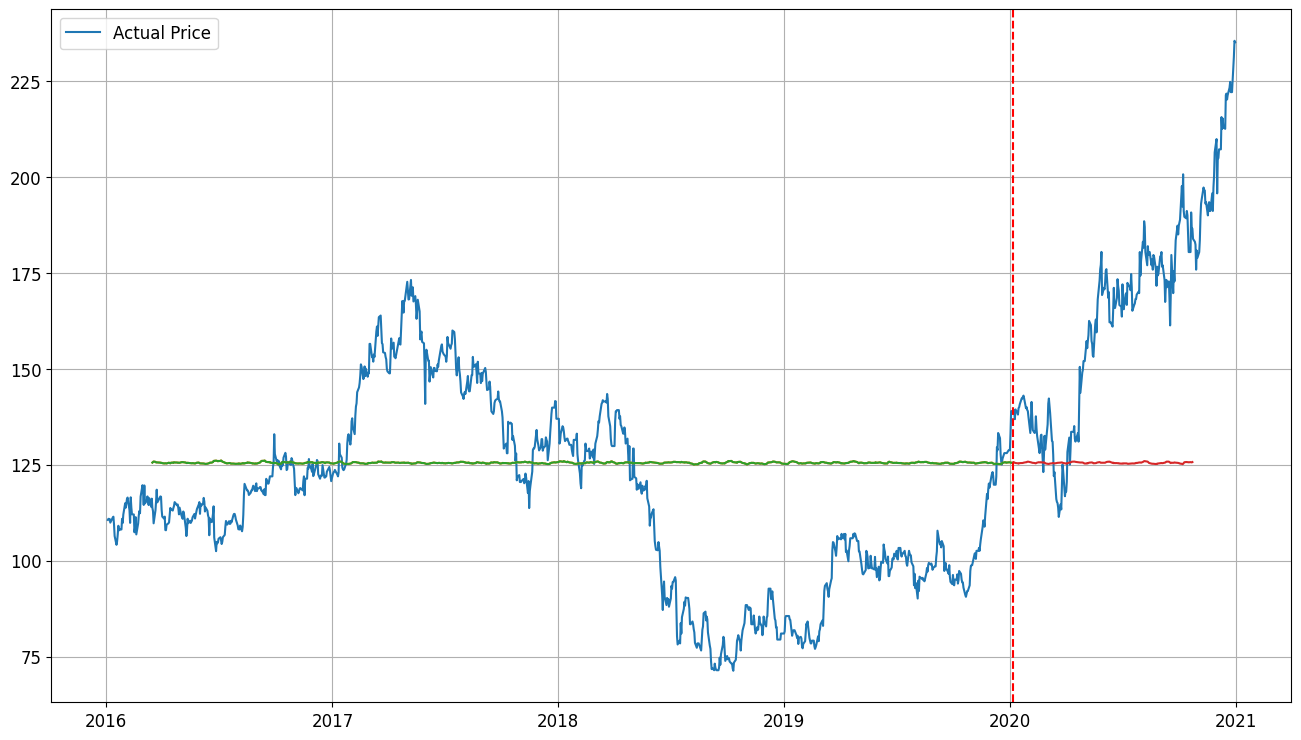

In [ ]:
# plot baseline and predictions
plt.plot(budimex_data, label='Actual Price')
plt.plot(budimex_data.index, trainPredictPlot)
plt.plot(budimex_data.index, testPredictPlot)
plt.axvline(x=budimex_data.index[len(train_budimex)], c='r', linestyle='--')
plt.legend()
plt.show()